# QBUS2820 Assignment 1

**SID:** 510575452

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_ceres_residuals
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, Normalizer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Loading in Dataset

In [3]:
heating_load_training_data = pd.read_csv('data/HeatingLoad_training.csv')
heating_load_test_without_HL_data = pd.read_csv(
    'data/HeatingLoad_test_without_HL.csv')

# EDA

## Looking at key characteristics of the dataset

In [4]:
heating_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,18.56,30.36,1,13.75,453.67,3.89,0.65,275.89
1,13.82,9.64,0,18.70,138.85,0.95,0.55,208.02
2,36.47,8.44,1,18.23,190.31,4.71,0.56,234.86
3,23.23,18.71,1,21.89,313.15,8.51,0.25,243.89
4,11.62,11.95,0,19.49,117.53,1.57,0.58,205.94


In [5]:
heating_load_training_data.columns

Index(['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature',
       'SunlightExposure', 'WindSpeed', 'OccupancyRate', 'HeatingLoad'],
      dtype='object')

In [6]:
heating_load_training_data.shape

(10000, 8)

## Data Cleaning

### Removing null values

In [7]:
# drop nan values
heating_load_training_data = heating_load_training_data.dropna()


## Looking at the information of the dataset

In [8]:
heating_load_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BuildingAge         10000 non-null  float64
 1   BuildingHeight      10000 non-null  float64
 2   Insulation          10000 non-null  int64  
 3   AverageTemperature  10000 non-null  float64
 4   SunlightExposure    10000 non-null  float64
 5   WindSpeed           10000 non-null  float64
 6   OccupancyRate       10000 non-null  float64
 7   HeatingLoad         10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


## Looking at the description of the dataset

In [9]:
heating_load_training_data.describe()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,22.765466,20.792105,0.596000,18.024851,271.361610,4.490681,0.500124,260.078634
std,12.385964,16.882672,0.490722,4.090699,229.275176,2.531248,0.221971,74.591892
min,2.990000,3.070000,0.000000,1.680000,1.150000,0.070000,0.010000,173.680000
25%,14.250000,9.310000,0.000000,15.270000,100.082500,2.610000,0.330000,218.087500
50%,20.090000,15.020000,1.000000,18.020000,182.435000,4.100000,0.500000,236.800000
75%,28.092500,25.830000,1.000000,20.810000,407.090000,5.960000,0.670000,270.350000
max,153.880000,106.360000,1.000000,34.340000,1250.710000,18.910000,1.000000,793.920000


## Checking for null values

In [10]:
heating_load_training_data.isnull().sum()

BuildingAge           0
BuildingHeight        0
Insulation            0
AverageTemperature    0
SunlightExposure      0
WindSpeed             0
OccupancyRate         0
HeatingLoad           0
dtype: int64

## Check how each of the variables interact with each other

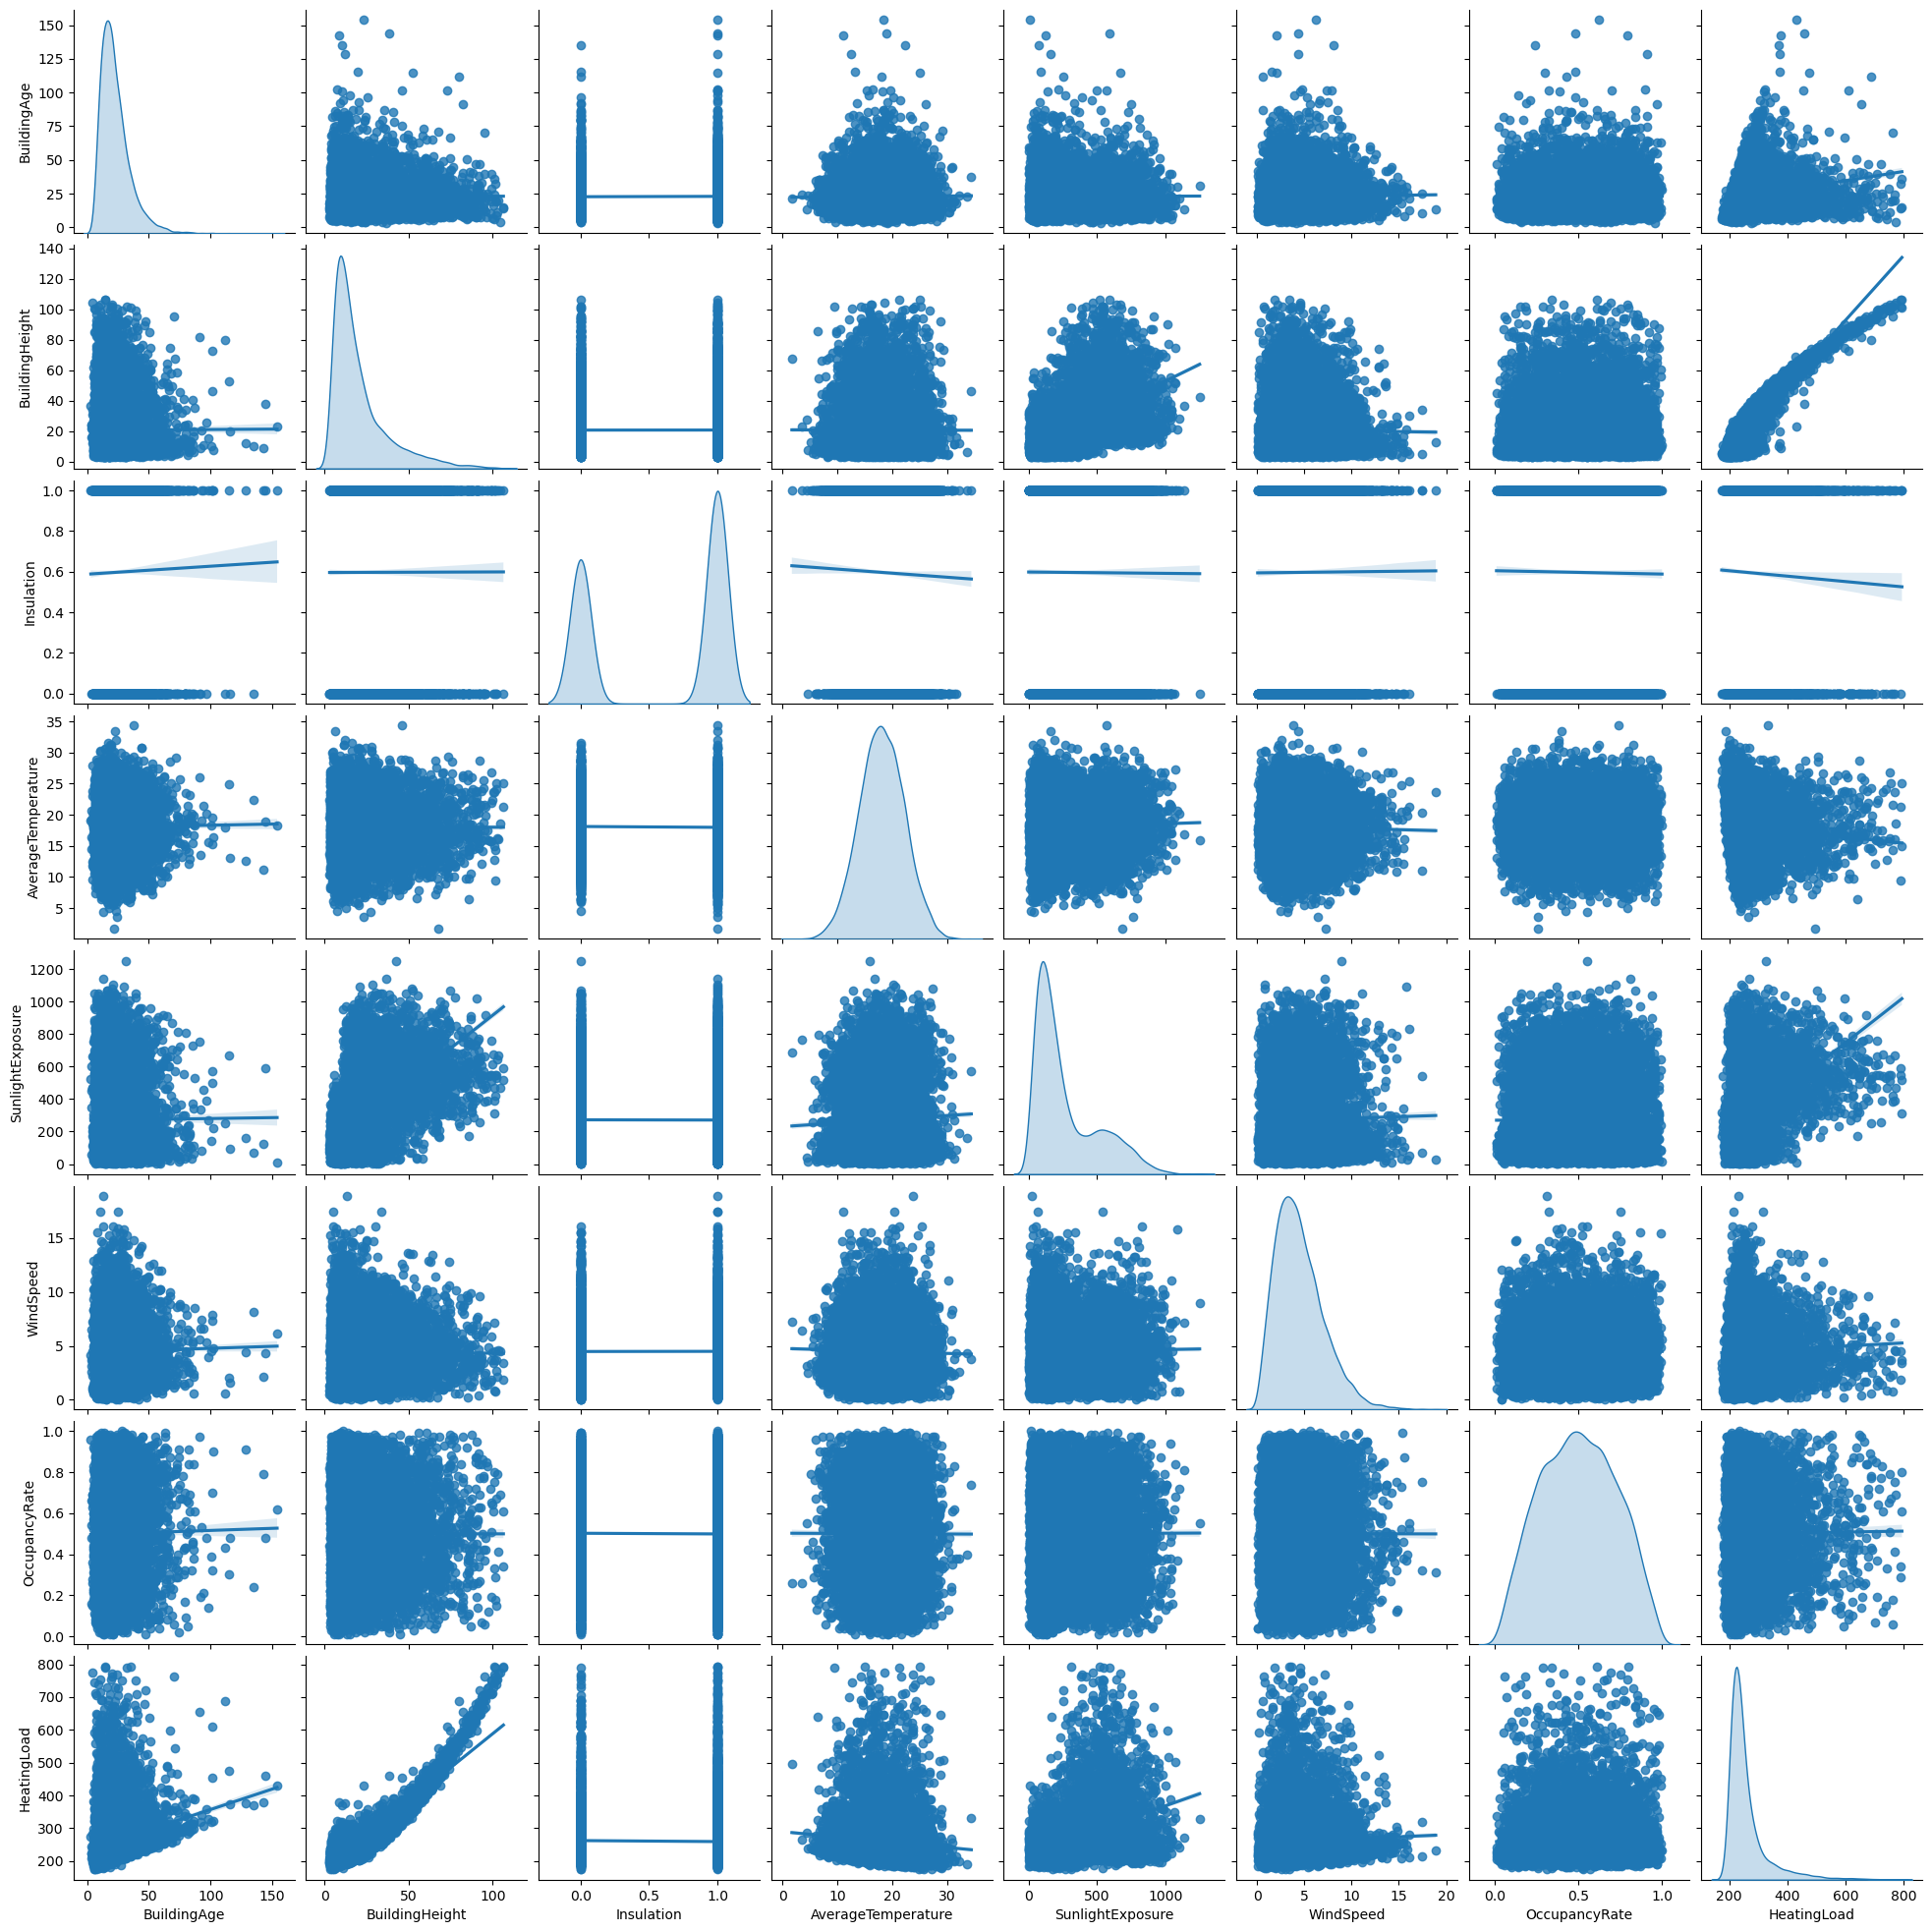

In [11]:
sns.pairplot(heating_load_training_data, kind='reg', diag_kind='kde')

## Checking for skewness

### Histogram

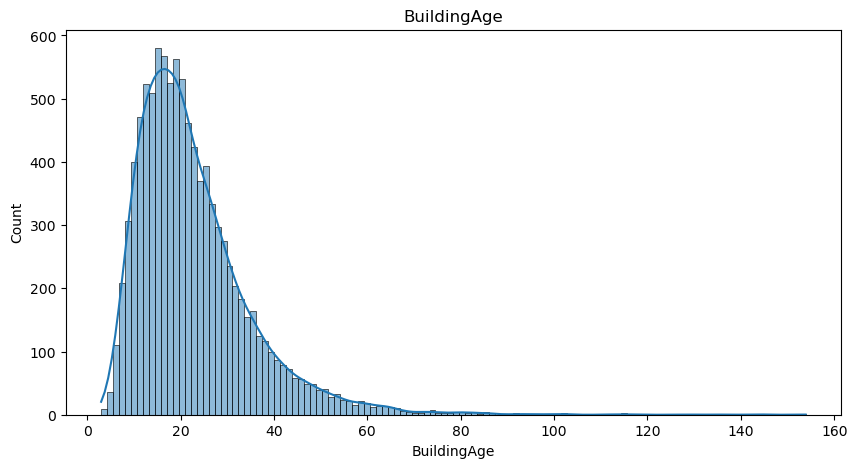

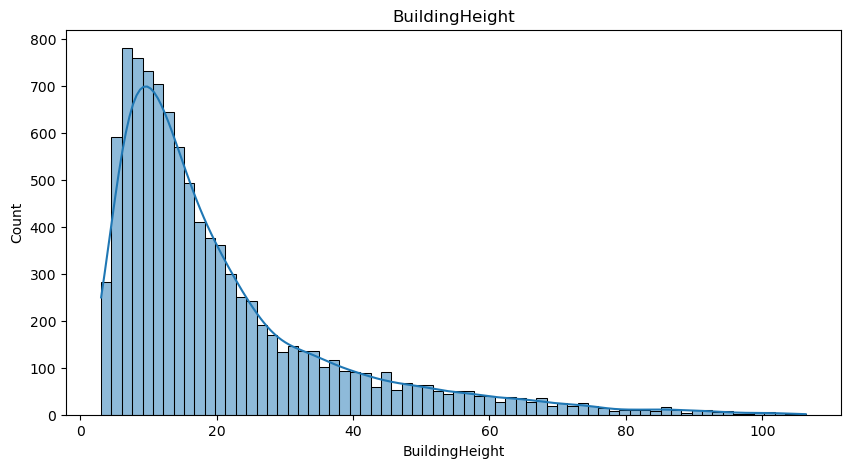

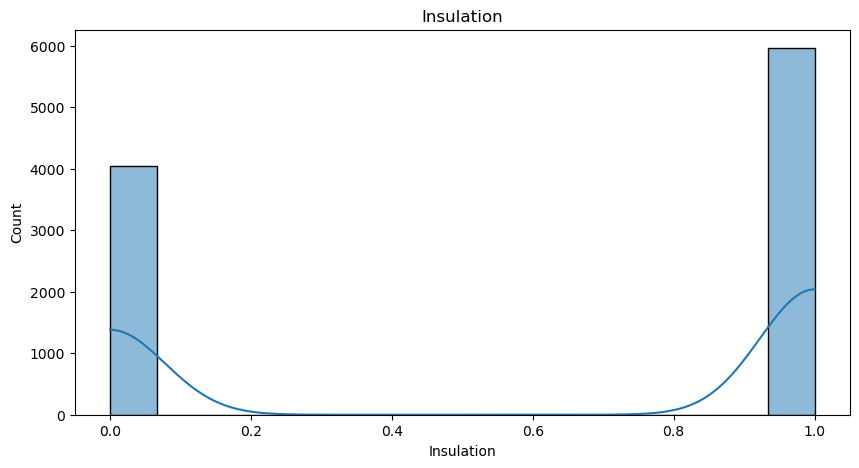

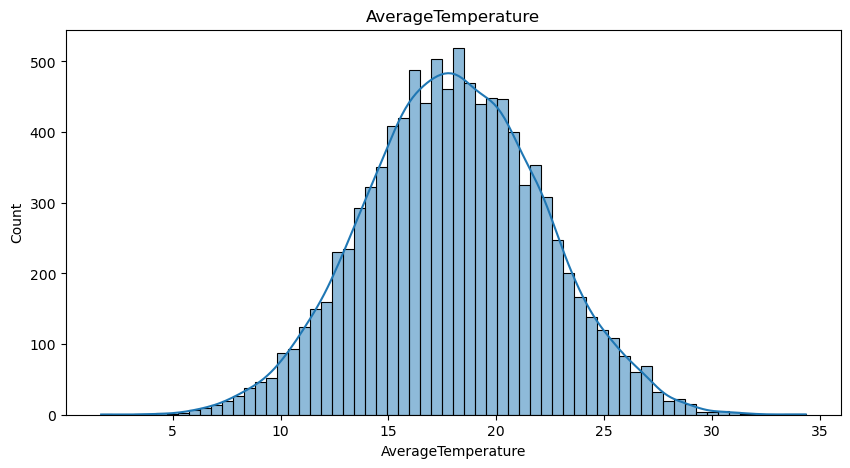

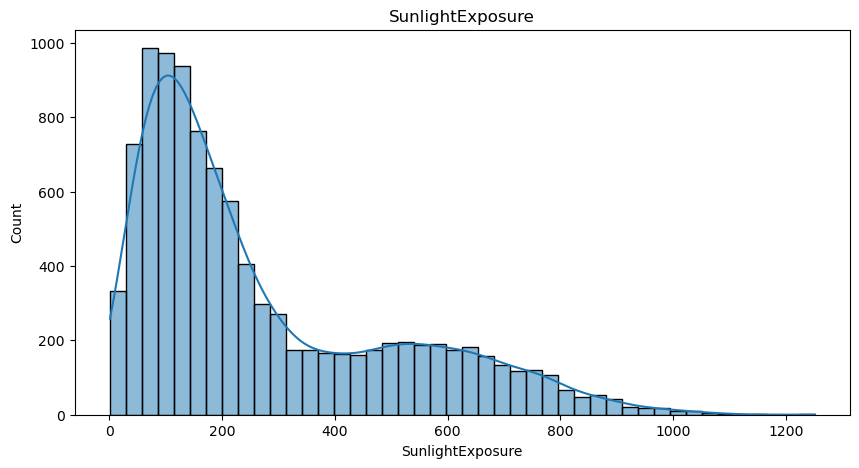

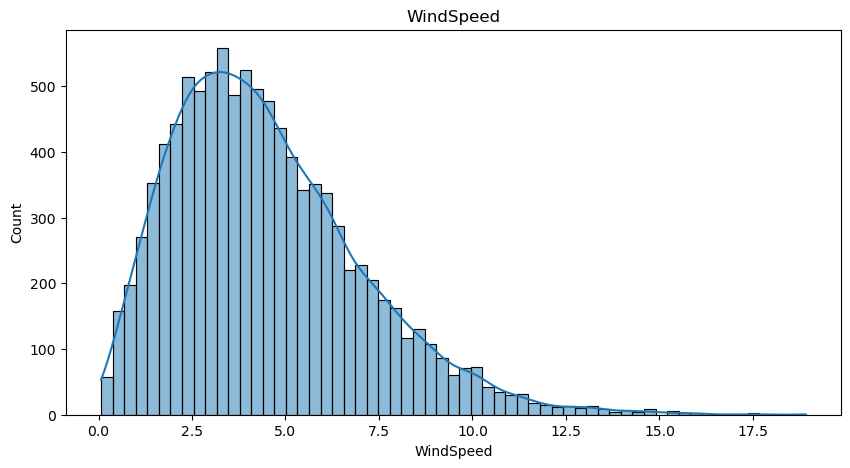

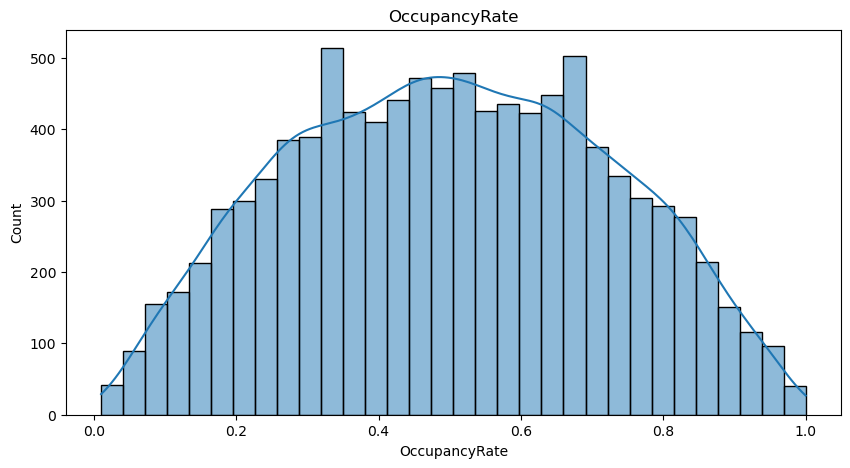

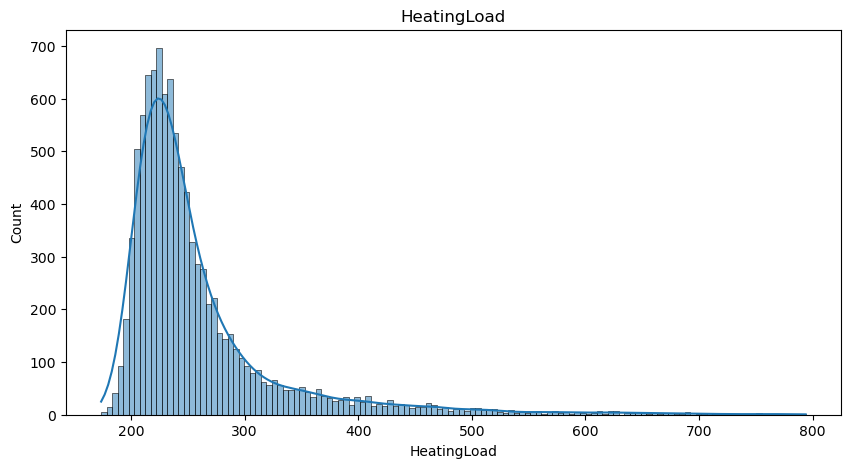

In [12]:
# Create a histogram of the variables with bell shaped distribution
for i in heating_load_training_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(heating_load_training_data[i], kde=True)
    plt.title(i)
    plt.show()

### QQ-plot

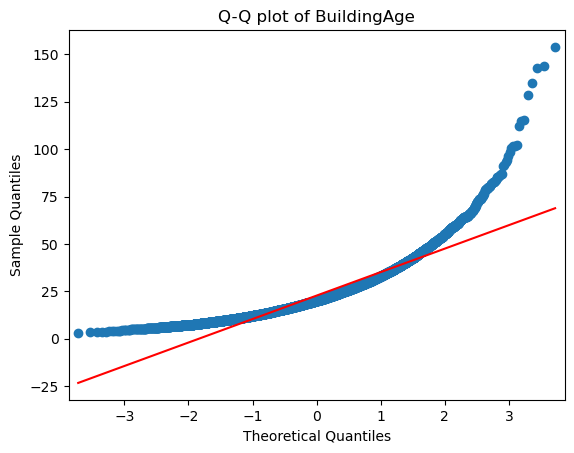

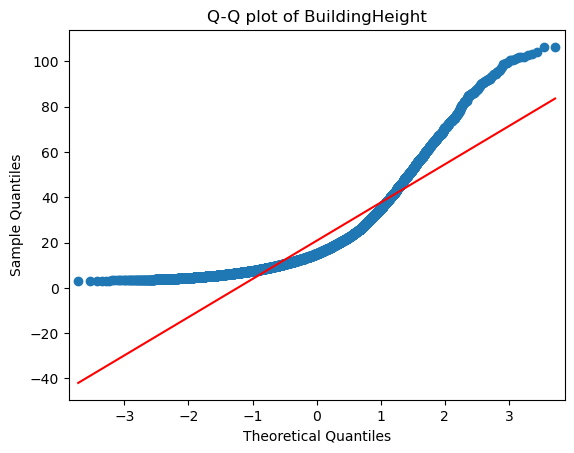

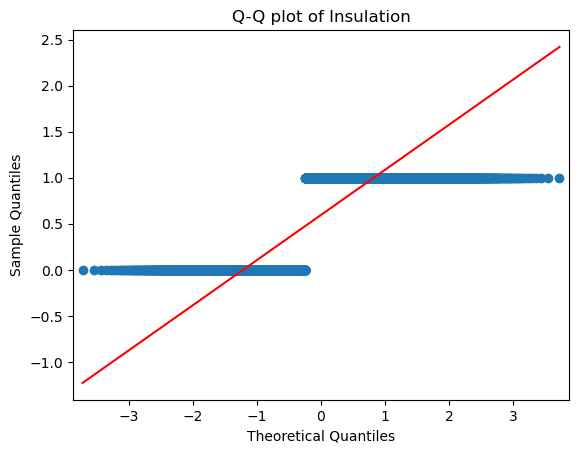

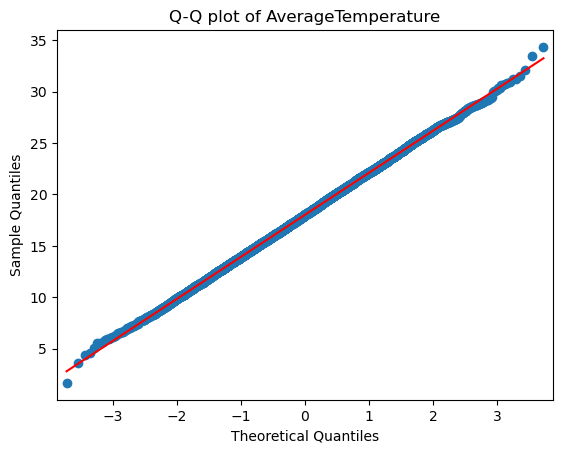

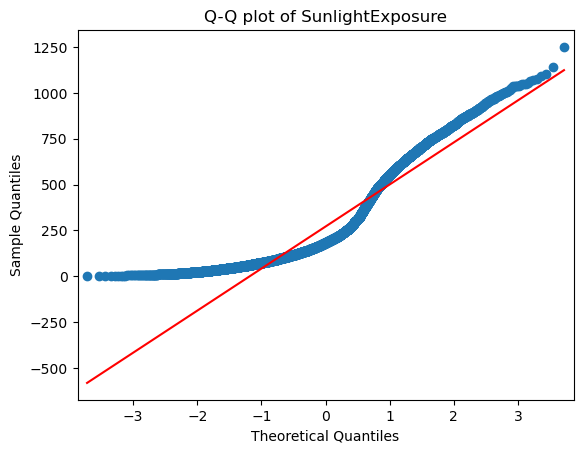

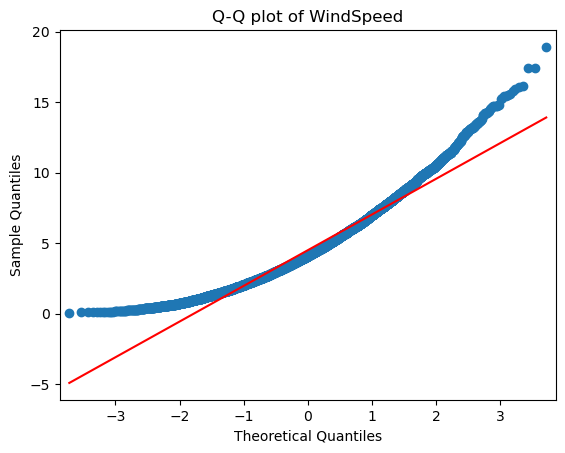

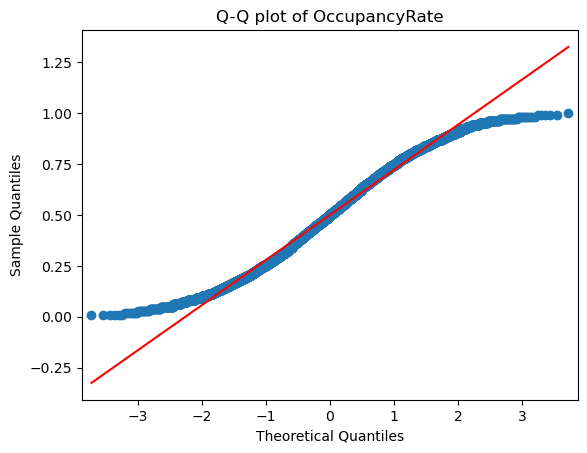

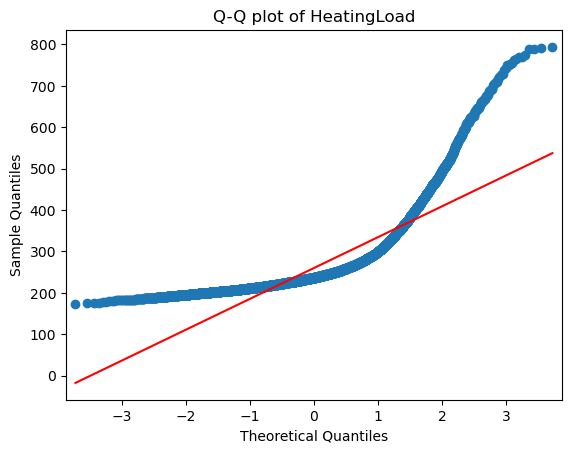

In [13]:
for i in heating_load_training_data.columns:
    sm.qqplot(heating_load_training_data[i], line='s')
    plt.title(f'Q-Q plot of {i}')
    plt.show()

# Correlation Analysis

In [14]:
correlations_heating_load_training_data = heating_load_training_data.corr()

## Correlation Heatmap

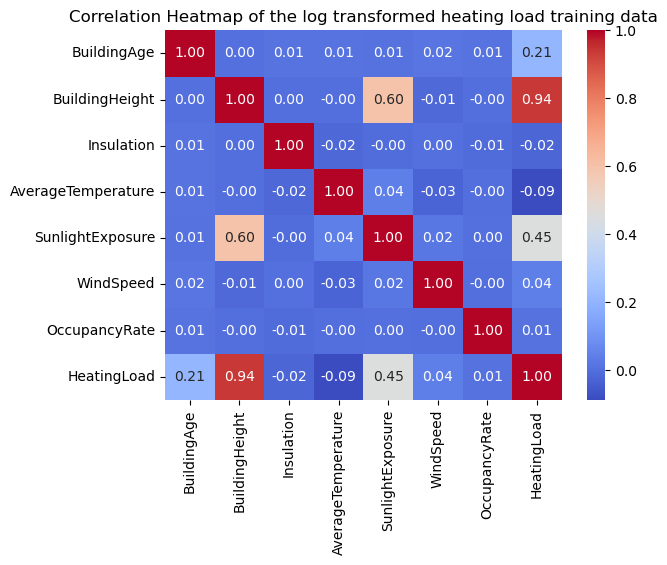

In [15]:
sns.heatmap(correlations_heating_load_training_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of the log transformed heating load training data')
plt.show()

# Model Development

## Full Data training and validation splits

In [16]:
X = heating_load_training_data.drop('HeatingLoad', axis=1)
y = heating_load_training_data['HeatingLoad']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2820)

In [17]:
kfold = KFold(n_splits=10, shuffle=True, random_state=2820)

## Linear Regression

In [18]:
linear_regression = LinearRegression()

sfs_linear_regression = SFS(
    linear_regression, 
    k_features='best', 
    forward=True, 
    verbose=2, 
    scoring='neg_mean_squared_error', 
    cv=kfold)

sfs_linear_regression.fit(X_train, y_train)


[2024-09-23 21:50:59] Features: 1/7 -- score: -664.5002134607855
[2024-09-23 21:50:59] Features: 2/7 -- score: -435.9953264622712
[2024-09-23 21:50:59] Features: 3/7 -- score: -338.41345121780057
[2024-09-23 21:50:59] Features: 4/7 -- score: -302.0177265136214
[2024-09-23 21:50:59] Features: 5/7 -- score: -284.8701664222082
[2024-09-23 21:51:00] Features: 6/7 -- score: -281.29793261774734
[2024-09-23 21:51:00] Features: 7/7 -- score: -280.9889204882428

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=LinearRegression(), k_features=(1, 7),
                          scoring='neg_mean_squared_error', verbose=2)

In [20]:
pd.DataFrame.from_dict(sfs_linear_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-626.7461712799578, -677.5720590458773, -609....",-664.500213,"(BuildingHeight,)",22.608446,30.440355,10.146785
2,"(0, 1)","[-435.8120511356286, -436.4522490084913, -369....",-435.995326,"(BuildingAge, BuildingHeight)",18.832386,25.35621,8.45207
3,"(0, 1, 4)","[-342.5529871097752, -341.19814589126094, -289...",-338.413451,"(BuildingAge, BuildingHeight, SunlightExposure)",14.457603,19.465937,6.488646
4,"(0, 1, 3, 4)","[-321.28820095704526, -319.02807934580727, -24...",-302.017727,"(BuildingAge, BuildingHeight, AverageTemperatu...",16.855798,22.694902,7.564967
5,"(0, 1, 3, 4, 5)","[-308.0564921607234, -301.3315431644917, -237....",-284.870166,"(BuildingAge, BuildingHeight, AverageTemperatu...",15.045027,20.256853,6.752284
6,"(0, 1, 2, 3, 4, 5)","[-304.6062401568828, -300.3314830769205, -237....",-281.297933,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.412954,19.405821,6.468607
7,"(0, 1, 2, 3, 4, 5, 6)","[-304.65426867163353, -300.0451960113155, -238...",-280.98892,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.288947,19.238856,6.412952


In [147]:
# Getting the best subset features
print(sfs_linear_regression.k_feature_names_)
print(sfs_linear_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate')
(0, 1, 2, 3, 4, 5, 6)


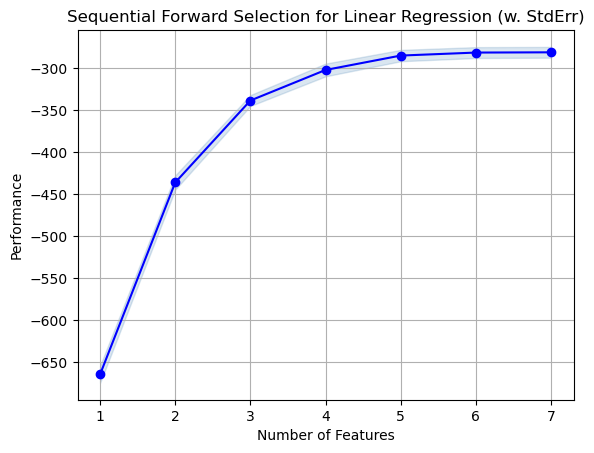

Number of features: 7
Loweest MSE: -280.9889204882428


In [42]:
plot_sfs(sfs_linear_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for Linear Regression (w. StdErr)')
plt.grid()
plt.show()

print(f'Best number of features: {len(sfs_linear_regression.k_feature_idx_)}')
print(f'Lowest MSE: {sfs_linear_regression.k_score_}')

In [63]:
# Get the best subset features for Linear Regression
best_subset_features_linear_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate']]

X_best_subset_features_linear_regression = best_subset_features_linear_regression
y_best_subset_features_linear_regression = y

X_train_best_subset_features_linear_regression, X_val_best_subset_features_linear_regression, y_train_best_subset_features_linear_regression, y_val_best_subset_features_linear_regression = train_test_split(
    X_best_subset_features_linear_regression, y_best_subset_features_linear_regression, test_size=0.2, random_state=2820)

In [64]:
linear_regression_OLS = sm.OLS(
    y_best_subset_features_linear_regression, X_best_subset_features_linear_regression).fit()
linear_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          9.195e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        00:42:18   Log-Likelihood:                         -49291.
No. Observations:               10000   AIC:                                  9.860e+04
Df Residuals:                    9993   BIC:                                  9.865e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.9053      0.026     73.591      0.000       1.855       1.956
BuildingHeight         4.8863      0.025    199.346      0.000       4.838       4.934
Insulation             8.8661      0.666     13.310      0.000       7.560      10.172
AverageTemperature     3.8115      0.055     69.901      0.000       3.705       3.918
SunlightExposure      -0.0471      0.002    -25.840      0.000      -0.051      -0.044
WindSpeed              5.1935      0.126     41.298      0.000       4.947       5.440
OccupancyRate         51.4702      1.395     36.887      0.000      48.735      54.205
==============================================================================
Omnibus:                       41.429   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.375
Skew:                           0.050   Prob(JB):                     1.56e-12
Kurtosis:                       3.347   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

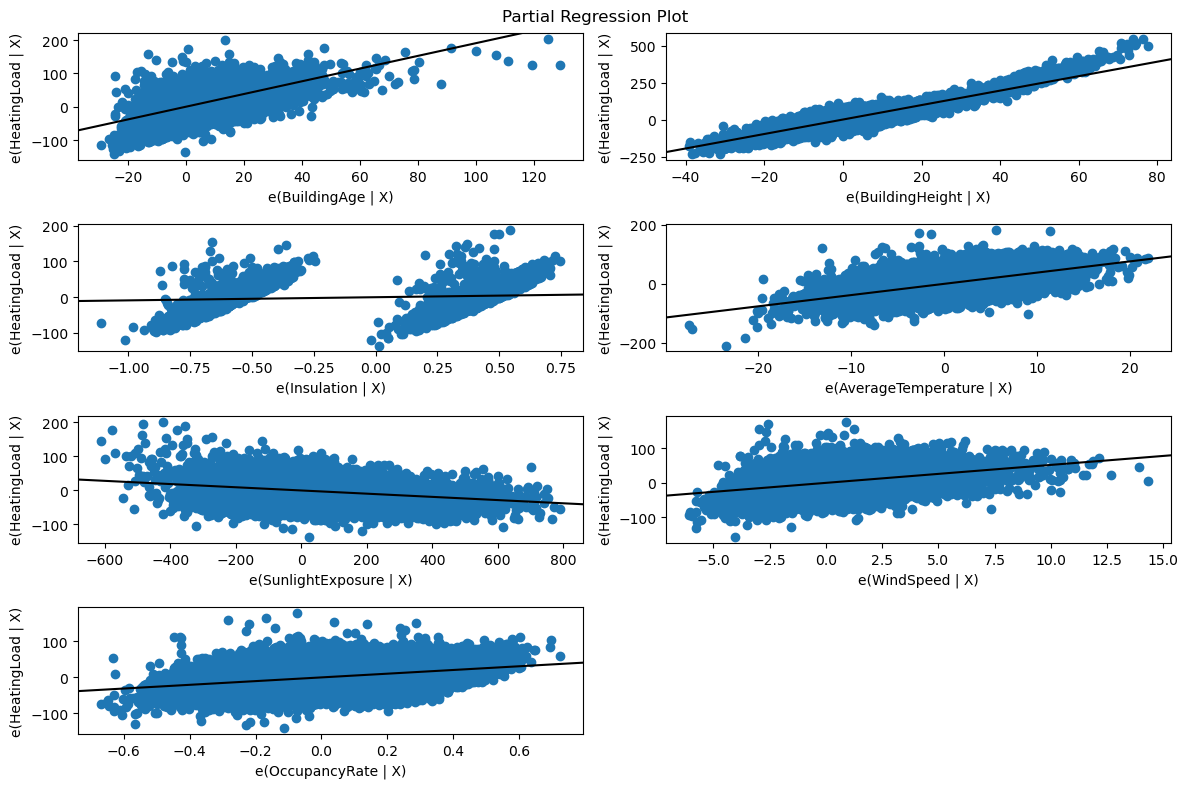

In [86]:
fig_linear_regression_OLS = plt.figure(figsize=(12, 8))
fig_linear_regression_OLS = sm.graphics.plot_partregress_grid(
    linear_regression_OLS, fig=fig_linear_regression_OLS)

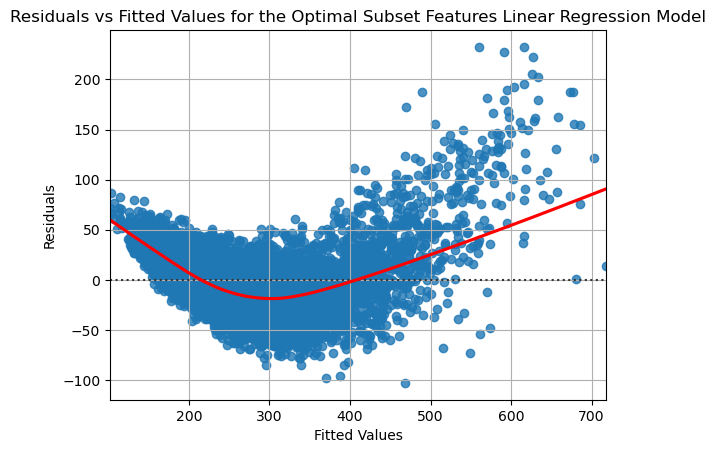

In [87]:
residuals_linear_regression = pd.DataFrame()
residuals_linear_regression['y_hat'] = linear_regression_OLS.fittedvalues
residuals_linear_regression['residuals'] = linear_regression_OLS.resid

sns.residplot(data=residuals_linear_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features Linear Regression Model')
plt.show()

In [70]:
optimised_linear_regression = linear_regression.fit(
    X_train_best_subset_features_linear_regression, y_train_best_subset_features_linear_regression)

y_pred_optimised_linear_regression = optimised_linear_regression.predict(
    X_val_best_subset_features_linear_regression)

mse_optimised_linear_regression = mean_squared_error(
    y_val_best_subset_features_linear_regression, y_pred_optimised_linear_regression)

print(f'Validation Mean Squared Error for Linear Regression: {mse_optimised_linear_regression}')

Validation Mean Squared Error: 311.30001835188324


## KNN

In [78]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

param_grid_knn = {
    'kneighborsregressor__n_neighbors': range(1, 21),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2]
}

grid_search_knn = GridSearchCV(
    knn_pipe, param_grid=param_grid_knn, 
    cv=kfold, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1)

grid_search_knn.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__n_neighbors': range(1, 21),
                         'kneighborsregressor__p': [1, 2],
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_mean_squared_error')

In [79]:
print(f'Best MSE: {grid_search_knn.best_score_}')
print(f'Best Parameters: {grid_search_knn.best_params_}')

Best MSE: -254.67969239169355
Best Parameters: {'kneighborsregressor__n_neighbors': 6, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}


In [80]:
sfs_knn_regression = SFS(
    KNeighborsRegressor(n_neighbors=6,
                        weights='distance',
                        p=2),
    k_features='best',
    forward=True,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=kfold)

sfs_knn_regression.fit(X_train, y_train)


[2024-09-24 01:49:54] Features: 1/7 -- score: -500.4923903527301
[2024-09-24 01:49:54] Features: 2/7 -- score: -126.1179007620627
[2024-09-24 01:49:54] Features: 3/7 -- score: -76.75261546706578
[2024-09-24 01:49:55] Features: 4/7 -- score: -61.27429161995305
[2024-09-24 01:49:55] Features: 5/7 -- score: -59.639581197440556
[2024-09-24 01:49:55] Features: 6/7 -- score: -59.516031477475096
[2024-09-24 01:49:55] Features: 7/7 -- score: -205.86504130128077

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=KNeighborsRegressor(n_neighbors=6,
                                                        weights='distance'),
                          k_features=(1, 7), scoring='neg_mean_squared_error',
                          verbose=2)

In [81]:
pd.DataFrame.from_dict(sfs_knn_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-463.5351978489748, -542.5081109720687, -528....",-500.49239,"(BuildingHeight,)",25.467633,34.290008,11.430003
2,"(0, 1)","[-126.20255929218315, -129.12843299870647, -12...",-126.117901,"(BuildingAge, BuildingHeight)",5.005626,6.739651,2.24655
3,"(0, 1, 3)","[-77.38776972416196, -86.66163683406175, -69.6...",-76.752615,"(BuildingAge, BuildingHeight, AverageTemperature)",4.97496,6.698362,2.232787
4,"(0, 1, 3, 5)","[-55.80520435886301, -73.51977668123904, -54.5...",-61.274292,"(BuildingAge, BuildingHeight, AverageTemperatu...",4.924851,6.630895,2.210298
5,"(0, 1, 2, 3, 5)","[-53.97842205410982, -71.40137244713797, -52.6...",-59.639581,"(BuildingAge, BuildingHeight, Insulation, Aver...",4.90698,6.606832,2.202277
6,"(0, 1, 2, 3, 5, 6)","[-53.39760895726135, -71.30838805051954, -52.5...",-59.516031,"(BuildingAge, BuildingHeight, Insulation, Aver...",4.956094,6.67296,2.22432
7,"(0, 1, 2, 3, 4, 5, 6)","[-192.12940749696855, -266.0915764035744, -140...",-205.865041,"(BuildingAge, BuildingHeight, Insulation, Aver...",29.563134,39.804252,13.268084


In [146]:
print(sfs_knn_regression.k_feature_names_)
print(sfs_knn_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'WindSpeed', 'OccupancyRate')
(0, 1, 2, 3, 5, 6)


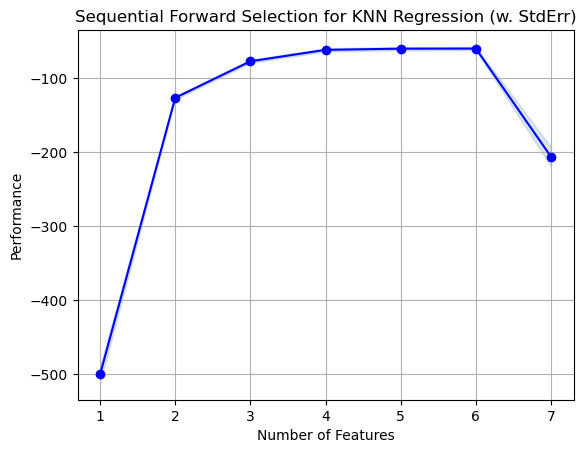

Number of features: 6
Loweest MSE: -59.516031477475096


In [83]:
plot_sfs(sfs_knn_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for KNN Regression (w. StdErr)')
plt.grid()
plt.show()

print(f'Best number of features: {len(sfs_knn_regression.k_feature_idx_)}')
print(f'Lowest MSE: {sfs_knn_regression.k_score_}')

In [84]:
best_subset_features_knn_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'WindSpeed', 'OccupancyRate']]

X_best_subset_features_knn_regression = best_subset_features_knn_regression
y_best_subset_features_knn_regression = y

X_train_best_subset_features_knn_regression, X_val_best_subset_features_knn_regression, y_train_best_subset_features_knn_regression, y_val_best_subset_features_knn_regression = train_test_split(
    X_best_subset_features_knn_regression, y_best_subset_features_knn_regression, test_size=0.2, random_state=2820)

In [85]:
knn_regression_OLS = sm.OLS(
    y_best_subset_features_knn_regression, X_best_subset_features_knn_regression).fit()
knn_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.005e+05
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        01:55:46   Log-Likelihood:                         -49615.
No. Observations:               10000   AIC:                                  9.924e+04
Df Residuals:                    9994   BIC:                                  9.928e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.8944      0.027     70.856      0.000       1.842       1.947
BuildingHeight         4.4983      0.020    224.803      0.000       4.459       4.538
Insulation             8.7752      0.688     12.756      0.000       7.427      10.124
AverageTemperature     3.6345      0.056     65.053      0.000       3.525       3.744
WindSpeed              5.0195      0.130     38.701      0.000       4.765       5.274
OccupancyRate         50.6840      1.441     35.178      0.000      47.860      53.508
==============================================================================
Omnibus:                      103.971   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.922
Skew:                           0.068   Prob(JB):                     3.44e-37
Kurtosis:                       3.620   Cond. No.                         160.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

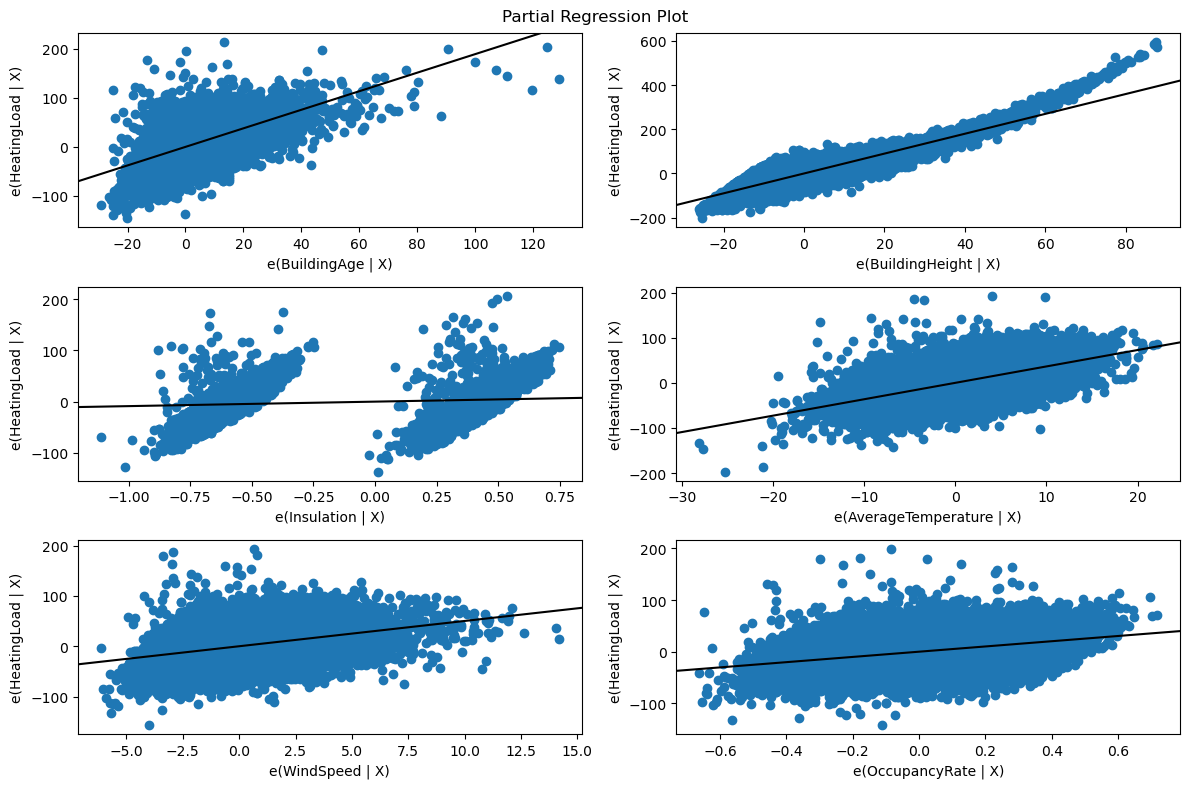

In [89]:
fig_knn_regression_OLS = plt.figure(figsize=(12, 8))
fig_knn_regression_OLS = sm.graphics.plot_partregress_grid(
    knn_regression_OLS, fig=fig_knn_regression_OLS)

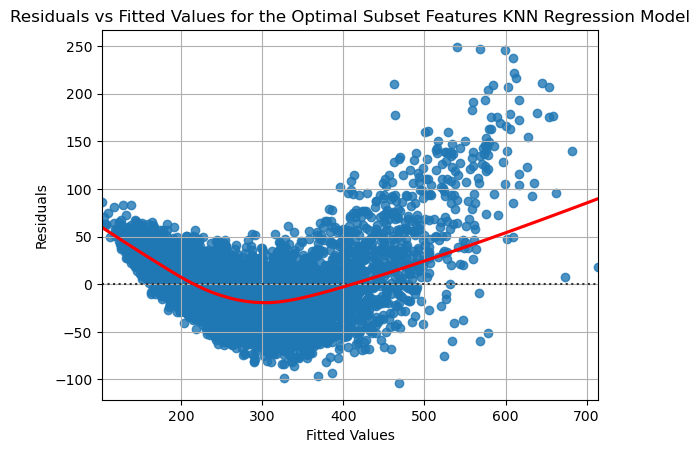

In [90]:
residuals_knn_regression = pd.DataFrame()
residuals_knn_regression['y_hat'] = knn_regression_OLS.fittedvalues
residuals_knn_regression['residuals'] = knn_regression_OLS.resid

sns.residplot(data=residuals_knn_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features KNN Regression Model')
plt.show()

In [91]:
optimised_knn_regression = KNeighborsRegressor(n_neighbors=6,
                                               weights='distance',
                                               p=2).fit(X_train_best_subset_features_knn_regression, y_train_best_subset_features_knn_regression)

y_pred_optimised_knn_regression = optimised_knn_regression.predict(
    X_val_best_subset_features_knn_regression)

mse_optimised_knn_regression = mean_squared_error(
    y_val_best_subset_features_knn_regression, y_pred_optimised_knn_regression)

print(f'Validation Mean Squared Error for KNN Regression: {mse_optimised_knn_regression}')


Validation Mean Squared Error: 57.61869068215493


## ElasticNet Regression

In [124]:
elasticnet_regression_pipe = make_pipeline(StandardScaler(), ElasticNet())

param_grid_elasticnet_regression = {
    'elasticnet__alpha': np.linspace(-5, 5, 8),
    'elasticnet__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
}

grid_search_elasticnet_regression = GridSearchCV(
    elasticnet_regression_pipe, 
    param_grid=param_grid_elasticnet_regression, 
    cv=kfold, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1)

grid_search_elasticnet_regression.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': array([-5.        , -3.57142857, -2.14285714, -0.71428571,  0.71428571,
        2.14285714,  3.57142857,  5.        ]),
                         'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [125]:
print(f'Best MSE: {grid_search_elasticnet_regression.best_score_}')
print(f'Best Parameters: {grid_search_elasticnet_regression.best_params_}')

Best MSE: -345.1812136873498
Best Parameters: {'elasticnet__alpha': 0.7142857142857144, 'elasticnet__l1_ratio': 0.9}


In [126]:
sfs_elasticnet_regression = SFS(
    ElasticNet(alpha=0.7142857142857144, l1_ratio=0.9),
    k_features='best',
    forward=True,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=kfold)

sfs_elasticnet_regression.fit(X_train, y_train)


[2024-09-24 02:48:21] Features: 1/7 -- score: -664.5033889587669
[2024-09-24 02:48:21] Features: 2/7 -- score: -436.00257978466243
[2024-09-24 02:48:21] Features: 3/7 -- score: -338.42432716000155
[2024-09-24 02:48:21] Features: 4/7 -- score: -302.06082567099537
[2024-09-24 02:48:21] Features: 5/7 -- score: -284.9970629315159
[2024-09-24 02:48:21] Features: 6/7 -- score: -283.5285014163786
[2024-09-24 02:48:21] Features: 7/7 -- score: -283.5285014163786

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=ElasticNet(alpha=0.7142857142857144,
                                               l1_ratio=0.9),
                          k_features=(1, 7), scoring='neg_mean_squared_error',
                          verbose=2)

In [128]:
pd.DataFrame.from_dict(sfs_elasticnet_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-626.6628995854946, -677.836550763305, -608.9...",-664.503389,"(BuildingHeight,)",22.691157,30.551719,10.183906
2,"(0, 1)","[-435.7809168775091, -436.48129971239905, -368...",-436.00258,"(BuildingAge, BuildingHeight)",18.877167,25.416504,8.472168
3,"(0, 1, 4)","[-342.4595575947629, -341.1963023170874, -289....",-338.424327,"(BuildingAge, BuildingHeight, SunlightExposure)",14.483083,19.500243,6.500081
4,"(0, 1, 3, 4)","[-320.66858595053856, -318.798465425363, -246....",-302.060826,"(BuildingAge, BuildingHeight, AverageTemperatu...",16.803886,22.625008,7.541669
5,"(0, 1, 3, 4, 5)","[-307.1577867564767, -301.1964170178237, -237....",-284.997063,"(BuildingAge, BuildingHeight, AverageTemperatu...",15.068507,20.288467,6.762822
6,"(0, 1, 2, 3, 4, 5)","[-305.6498641026354, -300.18252919935776, -236...",-283.528501,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.925547,20.095983,6.698661
7,"(0, 1, 2, 3, 4, 5, 6)","[-305.6498641026354, -300.18252919935776, -236...",-283.528501,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.925547,20.095983,6.698661


In [145]:
print(sfs_elasticnet_regression.k_feature_names_)
print(sfs_elasticnet_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed')
(0, 1, 2, 3, 4, 5)


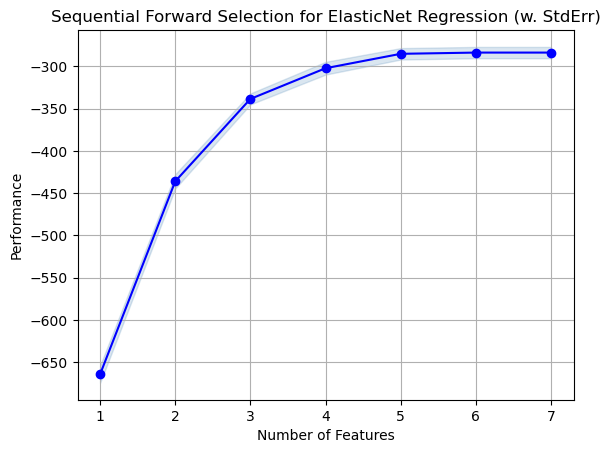

In [130]:
plot_sfs(sfs_elasticnet_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for ElasticNet Regression (w. StdErr)')
plt.grid()
plt.show()

In [131]:
print(f'Best number of features: {len(sfs_elasticnet_regression.k_feature_idx_)}')
print(f'Lowest MSE: {sfs_elasticnet_regression.k_score_}')

Best number of features: 6
Lowest MSE: -283.5285014163786


In [135]:
best_subset_features_elasticnet_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed']]
X_best_subset_features_elasticnet_regression = best_subset_features_elasticnet_regression
y_best_subset_features_elasticnet_regression = y

X_train_best_subset_features_elasticnet_regression, X_val_best_subset_features_elasticnet_regression, y_train_best_subset_features_elasticnet_regression, y_val_best_subset_features_elasticnet_regression = train_test_split(
    X_best_subset_features_elasticnet_regression, y_best_subset_features_elasticnet_regression, test_size=0.2, random_state=2820)

In [136]:
elasticnet_regression_OLS = sm.OLS(
    y_best_subset_features_elasticnet_regression, X_best_subset_features_elasticnet_regression).fit()
elasticnet_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          9.423e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        02:54:20   Log-Likelihood:                         -49929.
No. Observations:               10000   AIC:                                  9.987e+04
Df Residuals:                    9994   BIC:                                  9.991e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            2.0351      0.027     74.439      0.000       1.981       2.089
BuildingHeight         4.9372      0.026    189.277      0.000       4.886       4.988
Insulation            10.8823      0.708     15.380      0.000       9.495      12.269
AverageTemperature     4.7271      0.052     91.351      0.000       4.626       4.829
SunlightExposure      -0.0457      0.002    -23.495      0.000      -0.049      -0.042
WindSpeed              5.8114      0.133     43.746      0.000       5.551       6.072
==============================================================================
Omnibus:                       13.050   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.232
Skew:                          -0.009   Prob(JB):                     0.000492
Kurtosis:                       3.190   Cond. No.                         708.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

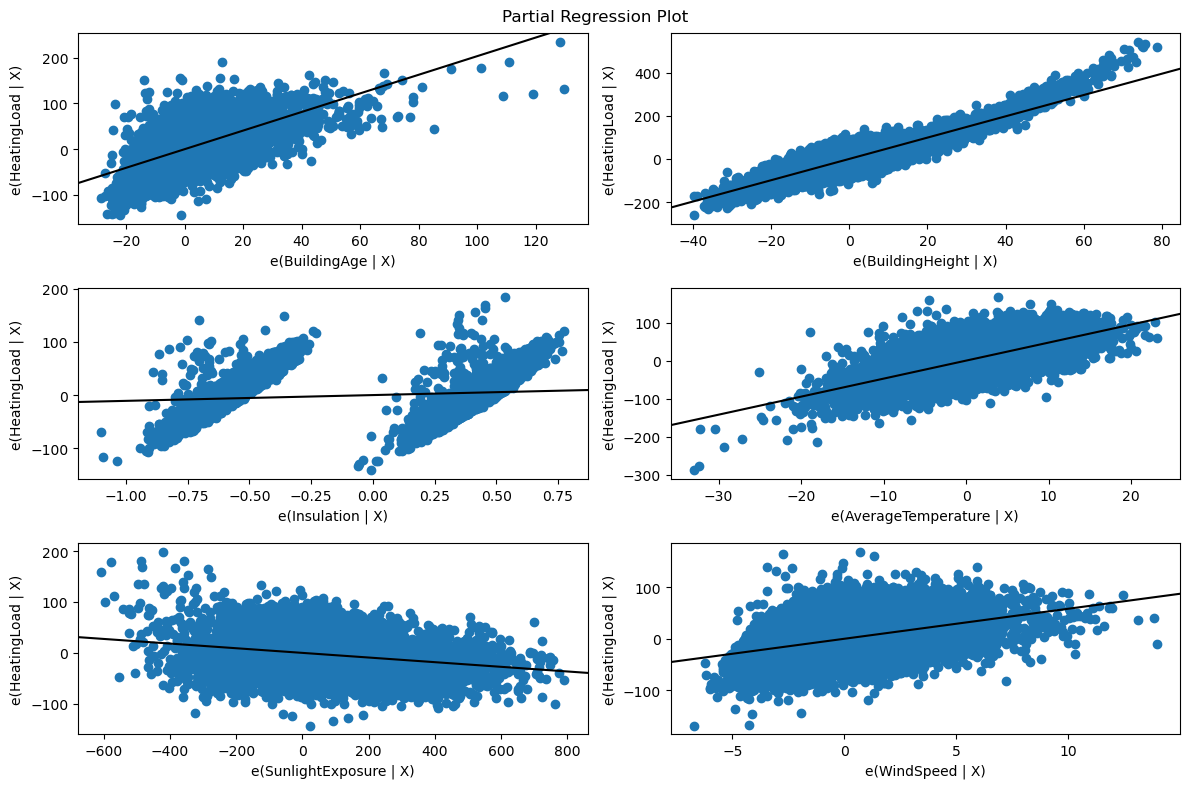

In [137]:
fig_elasticnet_regression_OLS = plt.figure(figsize=(12, 8))
fig_elasticnet_regression_OLS = sm.graphics.plot_partregress_grid(
    elasticnet_regression_OLS, fig=fig_elasticnet_regression_OLS)

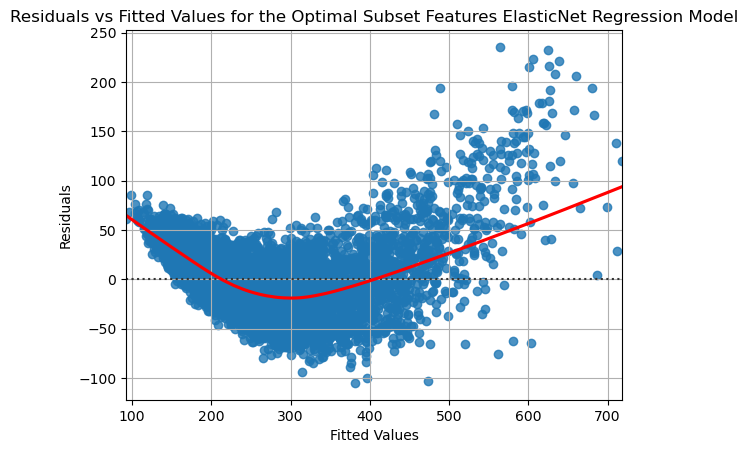

In [138]:
residuals_elasticnet_regression = pd.DataFrame()
residuals_elasticnet_regression['y_hat'] = elasticnet_regression_OLS.fittedvalues
residuals_elasticnet_regression['residuals'] = elasticnet_regression_OLS.resid

sns.residplot(data=residuals_elasticnet_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features ElasticNet Regression Model')
plt.show()

In [139]:
optimised_elasticnet_regression = ElasticNet(alpha=0.7142857142857144, l1_ratio=0.9).fit(
    X_train_best_subset_features_elasticnet_regression, y_train_best_subset_features_elasticnet_regression)

y_pred_optimised_elasticnet_regression = optimised_elasticnet_regression.predict(
    X_val_best_subset_features_elasticnet_regression)

mse_optimised_elasticnet_regression = mean_squared_error(
    y_val_best_subset_features_elasticnet_regression, y_pred_optimised_elasticnet_regression)

print(f'Validation Mean Squared Error for ElasticNet Regression: {mse_optimised_elasticnet_regression}')

Validation Mean Squared Error: 312.842585475894


## Ridge Regression

In [140]:
ridge_regression_pipe = make_pipeline(StandardScaler(), Ridge())

param_grid_ridge_regression = {
    'ridge__alpha': np.linspace(-5, 5, 8),
}

grid_search_ridge_regression = GridSearchCV(
    ridge_regression_pipe,
    param_grid=param_grid_ridge_regression,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

grid_search_ridge_regression.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([-5.        , -3.57142857, -2.14285714, -0.71428571,  0.71428571,
        2.14285714,  3.57142857,  5.        ])},
             scoring='neg_mean_squared_error')

In [141]:
print(f'Best MSE: {grid_search_ridge_regression.best_score_}')
print(f'Best Parameters: {grid_search_ridge_regression.best_params_}')

Best MSE: -280.989134653899
Best Parameters: {'ridge__alpha': 0.7142857142857144}


In [142]:
sfs_ridge_regression = SFS(
    Ridge(alpha=0.7142857142857144),
    k_features='best',
    forward=True,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=kfold)

sfs_ridge_regression.fit(X_train, y_train)


[2024-09-24 02:57:57] Features: 1/7 -- score: -664.500213398249
[2024-09-24 02:57:57] Features: 2/7 -- score: -435.99532669705803
[2024-09-24 02:57:57] Features: 3/7 -- score: -338.41345186533897
[2024-09-24 02:57:57] Features: 4/7 -- score: -302.0177266738002
[2024-09-24 02:57:57] Features: 5/7 -- score: -284.87016530130745
[2024-09-24 02:57:57] Features: 6/7 -- score: -281.2978999174186
[2024-09-24 02:57:57] Features: 7/7 -- score: -280.9887909690978

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=Ridge(alpha=0.7142857142857144),
                          k_features=(1, 7), scoring='neg_mean_squared_error',
                          verbose=2)

In [143]:
pd.DataFrame.from_dict(sfs_ridge_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-626.7461333918609, -677.5721733224814, -609....",-664.500213,"(BuildingHeight,)",22.608482,30.440404,10.146801
2,"(0, 1)","[-435.81205610687306, -436.45226773029236, -36...",-435.995327,"(BuildingAge, BuildingHeight)",18.83241,25.356243,8.452081
3,"(0, 1, 4)","[-342.55296684503463, -341.1981490481955, -289...",-338.413452,"(BuildingAge, BuildingHeight, SunlightExposure)",14.457622,19.465962,6.488654
4,"(0, 1, 3, 4)","[-321.28809025355883, -319.02804175901116, -24...",-302.017727,"(BuildingAge, BuildingHeight, AverageTemperatu...",16.855804,22.69491,7.56497
5,"(0, 1, 3, 4, 5)","[-308.05629100467473, -301.33151677137727, -23...",-284.870165,"(BuildingAge, BuildingHeight, AverageTemperatu...",15.045049,20.256882,6.752294
6,"(0, 1, 2, 3, 4, 5)","[-304.60593258362906, -300.33023769958845, -23...",-281.2979,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.41322,19.406179,6.468726
7,"(0, 1, 2, 3, 4, 5, 6)","[-304.65296715835206, -300.0437968949307, -238...",-280.988791,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.289438,19.239517,6.413172


In [148]:
print(sfs_ridge_regression.k_feature_names_)
print(sfs_ridge_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate')
(0, 1, 2, 3, 4, 5, 6)


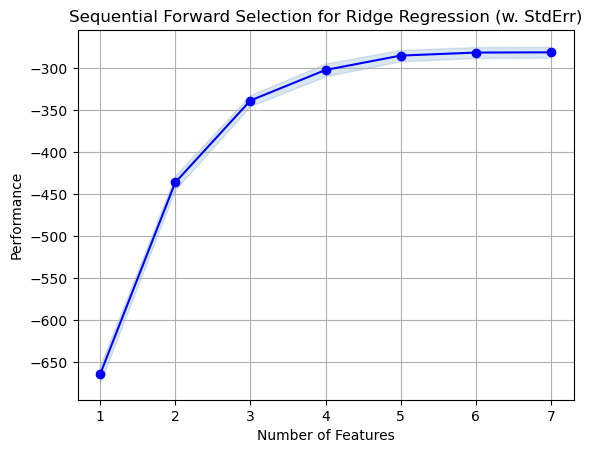

In [149]:
plot_sfs(sfs_ridge_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for Ridge Regression (w. StdErr)')
plt.grid()
plt.show()

In [150]:
print(f'Best number of features: {len(sfs_ridge_regression.k_feature_idx_)}')
print(f'Lowest MSE: {sfs_ridge_regression.k_score_}')

Best number of features: 7
Lowest MSE: -280.9887909690978


In [151]:
best_subset_features_ridge_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate']]
X_best_subset_features_ridge_regression = best_subset_features_ridge_regression
y_best_subset_features_ridge_regression = y

X_train_best_subset_features_ridge_regression, X_val_best_subset_features_ridge_regression, y_train_best_subset_features_ridge_regression, y_val_best_subset_features_ridge_regression = train_test_split(
    X_best_subset_features_ridge_regression, y_best_subset_features_ridge_regression, test_size=0.2, random_state=2820)

In [152]:
ridge_regression_OLS = sm.OLS(
    y_best_subset_features_ridge_regression, X_best_subset_features_ridge_regression).fit()
ridge_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          9.195e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        03:29:14   Log-Likelihood:                         -49291.
No. Observations:               10000   AIC:                                  9.860e+04
Df Residuals:                    9993   BIC:                                  9.865e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.9053      0.026     73.591      0.000       1.855       1.956
BuildingHeight         4.8863      0.025    199.346      0.000       4.838       4.934
Insulation             8.8661      0.666     13.310      0.000       7.560      10.172
AverageTemperature     3.8115      0.055     69.901      0.000       3.705       3.918
SunlightExposure      -0.0471      0.002    -25.840      0.000      -0.051      -0.044
WindSpeed              5.1935      0.126     41.298      0.000       4.947       5.440
OccupancyRate         51.4702      1.395     36.887      0.000      48.735      54.205
==============================================================================
Omnibus:                       41.429   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.375
Skew:                           0.050   Prob(JB):                     1.56e-12
Kurtosis:                       3.347   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

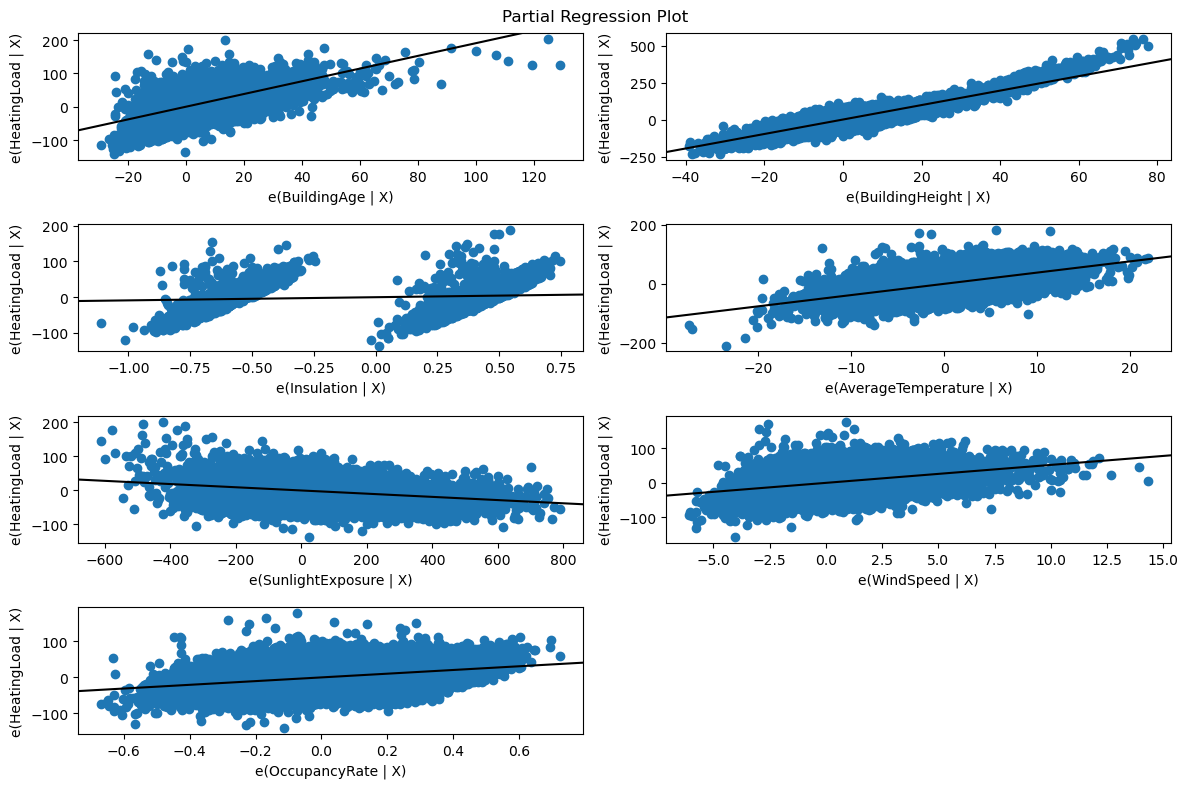

In [153]:
fig_ridge_regression_OLS = plt.figure(figsize=(12, 8))
fig_ridge_regression_OLS = sm.graphics.plot_partregress_grid(
    ridge_regression_OLS, fig=fig_ridge_regression_OLS)

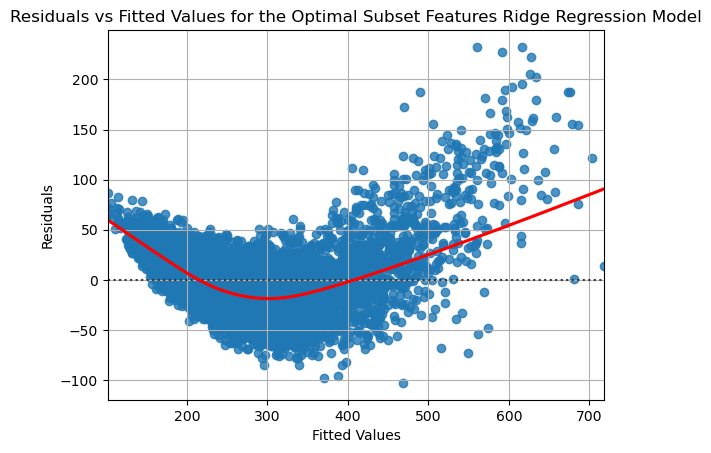

In [154]:
residuals_ridge_regression = pd.DataFrame()
residuals_ridge_regression['y_hat'] = ridge_regression_OLS.fittedvalues
residuals_ridge_regression['residuals'] = ridge_regression_OLS.resid

sns.residplot(data=residuals_ridge_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features Ridge Regression Model')
plt.show()

In [155]:
optimised_ridge_regression = Ridge(alpha=0.7142857142857144).fit(
    X_train_best_subset_features_ridge_regression, y_train_best_subset_features_ridge_regression)

y_pred_optimised_ridge_regression = optimised_ridge_regression.predict(
    X_val_best_subset_features_ridge_regression)

mse_optimised_ridge_regression = mean_squared_error(
    y_val_best_subset_features_ridge_regression, y_pred_optimised_ridge_regression)

print(f'Validation Mean Squared Error for Ridge Regression: {mse_optimised_ridge_regression}')

Validation Mean Squared Error: 311.2986359457121


## Lasso Regression

In [120]:
lasso_regression_pipe = make_pipeline(StandardScaler(), Lasso())

param_grid_lasso_regression = {
    'lasso__alpha': np.linspace(-5, 5, 8)
}

grid_search_lasso_regression = GridSearchCV(
    lasso_regression_pipe,
    param_grid=param_grid_lasso_regression,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

grid_search_lasso_regression.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([-5.        , -3.57142857, -2.14285714, -0.71428571,  0.71428571,
        2.14285714,  3.57142857,  5.        ])},
             scoring='neg_mean_squared_error')

In [121]:
print(f'Best MSE: {grid_search_lasso_regression.best_score_}')
print(f'Best Parameters: {grid_search_lasso_regression.best_params_}')

Best MSE: -285.95372165403666
Best Parameters: {'lasso__alpha': 0.7142857142857144}


In [156]:
sfs_lasso_regression = SFS(
    Lasso(alpha=0.7142857142857144),
    k_features='best',
    forward=True,
    verbose=2,
    scoring='neg_mean_squared_error',
    cv=kfold)

sfs_lasso_regression.fit(X_train, y_train)


[2024-09-24 03:33:17] Features: 1/7 -- score: -664.5021433349882
[2024-09-24 03:33:17] Features: 2/7 -- score: -436.00102913740045
[2024-09-24 03:33:17] Features: 3/7 -- score: -338.42137883895396
[2024-09-24 03:33:17] Features: 4/7 -- score: -302.0556825135028
[2024-09-24 03:33:17] Features: 5/7 -- score: -284.98410273195043
[2024-09-24 03:33:17] Features: 6/7 -- score: -283.5654205519432
[2024-09-24 03:33:17] Features: 7/7 -- score: -283.5654205519432

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=Lasso(alpha=0.7142857142857144),
                          k_features=(1, 7), scoring='neg_mean_squared_error',
                          verbose=2)

In [157]:
pd.DataFrame.from_dict(sfs_lasso_regression.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-626.6822068381863, -677.7731420451901, -609....",-664.502143,"(BuildingHeight,)",22.671352,30.525053,10.175018
2,"(0, 1)","[-435.77145196245124, -436.4671846793289, -368...",-436.001029,"(BuildingAge, BuildingHeight)",18.862799,25.397159,8.46572
3,"(0, 1, 4)","[-342.461797074754, -341.1896138831518, -289.1...",-338.421379,"(BuildingAge, BuildingHeight, SunlightExposure)",14.470321,19.48306,6.494353
4,"(0, 1, 3, 4)","[-320.6754101777206, -318.79256513753717, -246...",-302.055683,"(BuildingAge, BuildingHeight, AverageTemperatu...",16.792633,22.609856,7.536619
5,"(0, 1, 3, 4, 5)","[-307.18120298661427, -301.1746686938528, -237...",-284.984103,"(BuildingAge, BuildingHeight, AverageTemperatu...",15.052583,20.267026,6.755675
6,"(0, 1, 2, 3, 4, 5)","[-305.7006847271738, -300.15170039967563, -236...",-283.565421,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.919886,20.088361,6.69612
7,"(0, 1, 2, 3, 4, 5, 6)","[-305.7006847271738, -300.15170039967563, -236...",-283.565421,"(BuildingAge, BuildingHeight, Insulation, Aver...",14.919886,20.088361,6.69612


In [158]:
print(sfs_lasso_regression.k_feature_names_)
print(sfs_lasso_regression.k_feature_idx_)

('BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed')
(0, 1, 2, 3, 4, 5)


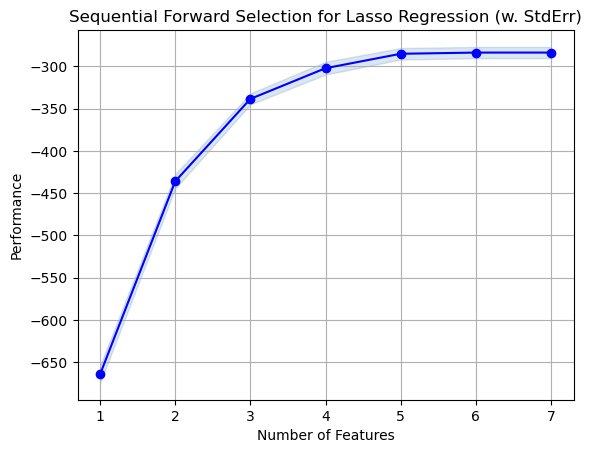

In [159]:
plot_sfs(sfs_lasso_regression.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for Lasso Regression (w. StdErr)')
plt.grid()
plt.show()

In [160]:
print(f'Best number of features: {len(sfs_lasso_regression.k_feature_idx_)}')
print(f'Lowest MSE: {sfs_lasso_regression.k_score_}')

Best number of features: 6
Lowest MSE: -283.5654205519432


In [161]:
best_subset_features_lasso_regression = heating_load_training_data[['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed']]
X_best_subset_features_lasso_regression = best_subset_features_lasso_regression
y_best_subset_features_lasso_regression = y

X_train_best_subset_features_lasso_regression, X_val_best_subset_features_lasso_regression, y_train_best_subset_features_lasso_regression, y_val_best_subset_features_lasso_regression = train_test_split(
    X_best_subset_features_lasso_regression, y_best_subset_features_lasso_regression, test_size=0.2, random_state=2820)


In [162]:
lasso_regression_OLS = sm.OLS(
    y_best_subset_features_lasso_regression, X_best_subset_features_lasso_regression).fit()
lasso_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          9.423e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):                        0.00
Time:                        03:35:22   Log-Likelihood:                         -49929.
No. Observations:               10000   AIC:                                  9.987e+04
Df Residuals:                    9994   BIC:                                  9.991e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            2.0351      0.027     74.439      0.000       1.981       2.089
BuildingHeight         4.9372      0.026    189.277      0.000       4.886       4.988
Insulation            10.8823      0.708     15.380      0.000       9.495      12.269
AverageTemperature     4.7271      0.052     91.351      0.000       4.626       4.829
SunlightExposure      -0.0457      0.002    -23.495      0.000      -0.049      -0.042
WindSpeed              5.8114      0.133     43.746      0.000       5.551       6.072
==============================================================================
Omnibus:                       13.050   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.232
Skew:                          -0.009   Prob(JB):                     0.000492
Kurtosis:                       3.190   Cond. No.                         708.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

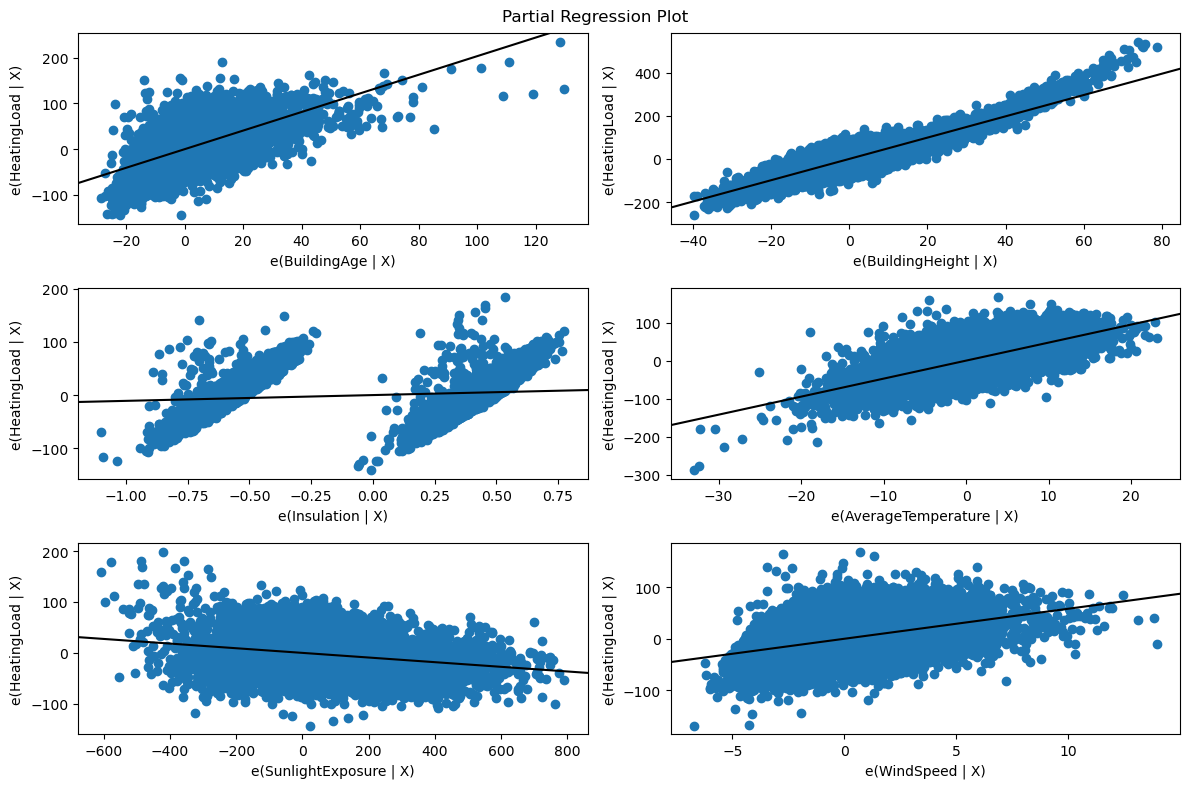

In [163]:
fig_lasso_regression_OLS = plt.figure(figsize=(12, 8))
fig_lasso_regression_OLS = sm.graphics.plot_partregress_grid(
    lasso_regression_OLS, fig=fig_lasso_regression_OLS)

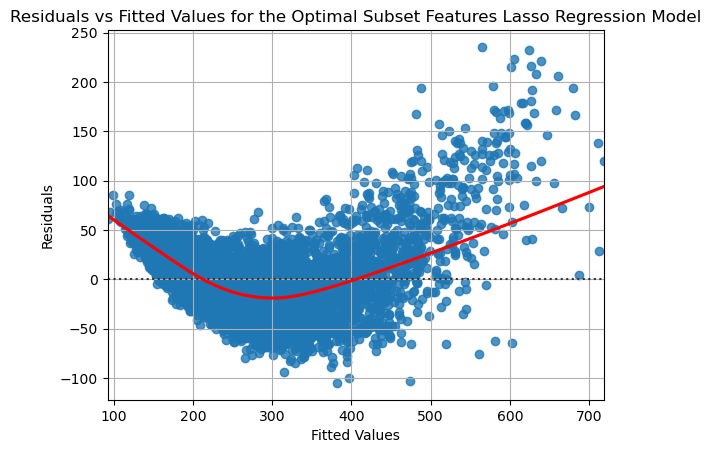

In [164]:
residuals_lasso_regression = pd.DataFrame()
residuals_lasso_regression['y_hat'] = lasso_regression_OLS.fittedvalues
residuals_lasso_regression['residuals'] = lasso_regression_OLS.resid

sns.residplot(data=residuals_lasso_regression, x='y_hat', y='residuals',
                lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.title('Residuals vs Fitted Values for the Optimal Subset Features Lasso Regression Model')
plt.show()

In [165]:
optimised_lasso_regression = Lasso(alpha=0.7142857142857144).fit(
    X_train_best_subset_features_lasso_regression, y_train_best_subset_features_lasso_regression)

y_pred_optimised_lasso_regression = optimised_lasso_regression.predict(
    X_val_best_subset_features_lasso_regression)

mse_optimised_lasso_regression = mean_squared_error(
    y_val_best_subset_features_lasso_regression, y_pred_optimised_lasso_regression)

print(f'Validation Mean Squared Error for Lasso Regression: {mse_optimised_lasso_regression}')

Validation Mean Squared Error for Lasso Regression: 312.8324312255016


# Code Chunk to run tests on unseen dataset

In [19]:
# HeatingLoad_test = pd.read_csv("HeatingLoad_test.csv")

# test_error = mean_squared_error(HeatingLoad_test['HeatingLoad'], heating_load_test_without_HL_data_predictions)

# print(test_error)